# Mixture Modeling

The idea in this case is to treat a single time-interval of urban growth as an unsupervised learning problem in which we aim to learn the mixture density giving the settlement likelihoods. 

One limitation of this model is that there are many more parameters to learn unless we impose a hard thresholding scheme for parameter-sharing. Another limitation is that it is much harder to learn explicitly from time-series. 

In [1]:
import numpy as np
from urban_growth.mixture_model import *
from matplotlib import pyplot as plt
from scipy.spatial import distance
%matplotlib inline

In [2]:
# Params

## Initial Configuration
L = 100
rho = .44
blur = 2

## Rural/Urban Size Threshold
T = 50

## Dynamical Parameters, not assuming that these are good ones. 

pars_1 = {'gamma_r' : 2.0,     # rural settlement more diffuse than urban
          'gamma_u' : 2.0,      
          'alpha_r' : .35,       
          'alpha_u' : .35,
          'beta_r'  : -10,      # low background rates
          'beta_u'  : -10}

truncation = None

geo = np.ones((L, L))

for i in np.arange(0, L):
    geo[:,i] = 1.0*i / L 

In [3]:
M0 = random_mat(L, rho, blur = blur)
m = mixture_model(M0 = M0, geo = geo)
m.make_dists()

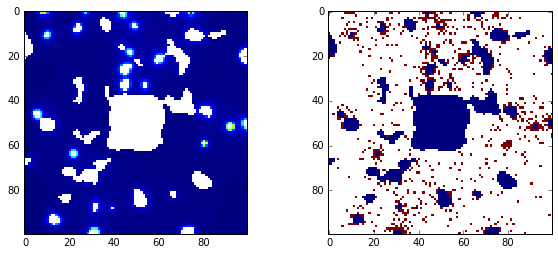

In [4]:
gamma = 2 + np.random.rand(len(m.dists))
alpha = np.random.rand(len(m.dists))
# alpha = np.sqrt([m.clusters[i+1].shape[0] for i in range(len(m.clusters))])

M = m.density(alpha, gamma)

fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(121)

ax1.imshow(M, interpolation = 'nearest')

ax2 = fig.add_subplot(122)
x = m.sample(n_samples = 1000, alpha = alpha, gamma = gamma)
to_viz = (x - m.M0)*2
to_viz[np.isnan(M)] = 1
to_viz[to_viz == 0] = np.nan
ax2.imshow(to_viz, interpolation = 'nearest')

In [5]:
alpha_prime = np.random.rand(len(alpha))
gamma_prime = 2 + np.random.rand(len(gamma))

v1 = m.log_likelihood(x, alpha = alpha, gamma = gamma, normalized = True)
v2 = m.log_likelihood(x, alpha = alpha_prime, gamma = gamma, normalized = True)
v3 = m.log_likelihood(x, alpha = alpha, gamma = gamma_prime, normalized = True)
v4 = m.log_likelihood(x, alpha = alpha_prime, gamma = gamma_prime, normalized = True)

np.round(np.array([v1, v2, v3, v4, np.sum((alpha_prime - alpha) ** 2),np.sum((gamma_prime - gamma) ** 2) ]), 3)

urban_growth/mixture_model.py:94: RuntimeWarning: divide by zero encountered in log
  lik = np.nansum((np.log(d) * X))
urban_growth/mixture_model.py:94: RuntimeWarning: invalid value encountered in multiply
  lik = np.nansum((np.log(d) * X))


array([-8.535, -8.738, -8.551, -8.787,  6.384,  4.972])

Conjecture: there are going to be some parameters about which the model is highly uncertain, and others about which it is quite confident. 

# E Step

In [6]:
m.E_step(alpha = alpha, gamma = gamma)

urban_growth/mixture_model.py:101: RuntimeWarning: invalid value encountered in divide
  self.Q = p / p.sum(axis = 0)


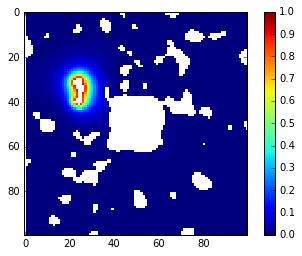

In [7]:
plt.imshow(m.Q[19], interpolation = 'nearest', vmin = 0, vmax = 1)
plt.colorbar()